### 모듈 불러오기

In [1]:
!pip install split-folders

In [2]:
import numpy as np
import keras
import tensorflow as tf
import splitfolders
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
import PIL
import glob, os, shutil, random
import splitfolders


### 안주 질환 데이터 압축해제

In [3]:
!unzip /content/drive/MyDrive/CV_project/data/안구질환/개_질환_최종.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: content/개/유루증/crop_D35_0cba4a73-60a5-11ec-8402-0a7404972c70.png  
  inflating: content/개/유루증/crop_D15_0d07ba38-60a5-11ec-8402-0a7404972c70.png  
  inflating: content/개/유루증/crop_D7_0cb3ddf9-60a5-11ec-8402-0a7404972c70.png  
  inflating: content/개/유루증/crop_D1_0cb523e5-60a5-11ec-8402-0a7404972c70.png  
  inflating: content/개/유루증/crop_D8_0f0fa739-60a5-11ec-8402-0a7404972c70.jpg  
  inflating: content/개/유루증/crop_D21_0d07cf5f-60a5-11ec-8402-0a7404972c70.png  
  inflating: content/개/유루증/crop_D5_37239aa8-60a5-11ec-8402-0a7404972c70.jpg  
  inflating: content/개/유루증/crop_D15_3656ef5c-60a5-11ec-8402-0a7404972c70.jpg  
  inflating: content/개/유루증/crop_D1_35fab06c-60a5-11ec-8402-0a7404972c70.jpg  
  inflating: content/개/유루증/crop_D14_0cd50543-60a5-11ec-8402-0a7404972c70.png  
  inflating: content/개/유루증/crop_D34_03a19319-60a5-11ec-8402-0a7404972c70.jpg  
  inflating: content/개/유루증/crop_D33_0cfbf3d4-60a5-11ec-8402-0a7404972c70.png  
  inflating: content/

### train, test, valid data 8:1:1로 나누기

In [5]:
splitfolders.ratio('/content/개', output='output_dir', ratio=(0.8, 0.1, 0.1))  # train/val/test = 8:1:1

Copying files: 68875 files [00:16, 4151.55 files/s]


In [6]:
train_path = 'output_dir/train'
val_path = 'output_dir/val'
test_path = 'output_dir/test'

## 넘파이 배열 및 데이터 정규화
* 0 ~ 255 사이의 값으로 변환 후 255 로 나누어 0 ~ 1 사아의 값으로 변경해야함
    * 너무 커서 아웃 오브 메모리 뜸
        * 배치 사이즈로 변경해서 정규화 시도 해봐야함

In [23]:
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape, labels.dtype)


(16, 400, 400, 3) (16,) <dtype: 'int32'>


In [25]:
img_width, img_height = 400, 400
batch_size = 16
num_classes = 10
last_activation = 'softmax'

train_ds = image_dataset_from_directory(
    train_path,
    batch_size=batch_size,
    image_size=(img_width, img_height),
    shuffle=True,
    label_mode='int'
)

valid_ds = image_dataset_from_directory(
    val_path,
    batch_size=batch_size,
    image_size=(img_width, img_height),
    shuffle=True,
    label_mode='int'
)

test_ds = image_dataset_from_directory(
    test_path,
    batch_size=batch_size,
    image_size=(img_width, img_height),
    shuffle=True,
    label_mode='int'
)

Found 55095 files belonging to 10 classes.
Found 6882 files belonging to 10 classes.
Found 6898 files belonging to 10 classes.


In [26]:
labels = train_ds.class_names
labels

['결막염',
 '백내장',
 '비궤양성각막질환',
 '색소침착성각막염',
 '안검내반증',
 '안검염',
 '안검종양',
 '유루증',
 '정상',
 '핵경화']

In [27]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))

In [28]:
# def load_images_to_array(data_dir):
#     images = []
#     labels = []
#     for label in os.listdir(data_dir):
#         label_dir = os.path.join(data_dir, label)
#         for filename in os.listdir(label_dir):
#             img_path = os.path.join(label_dir, filename)
#             img = Image.open(img_path).convert('RGB')

#             # 이미지 크기 조절 및 정규화 추가
#             img = img.resize((224, 224))  # 이미지 크기 조절
#             img_array = np.array(img) / 255.0  # 정규화

#             images.append(img_array)
#             labels.append(label)
#     return np.array(images), np.array(labels)

In [29]:
# train_images, train_labels = load_images_to_array(train)
# val_images, val_labels = load_images_to_array(val)
# test_images, test_labels = load_images_to_array(test)


## 합성곱 모듈 추가

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

### 합성곱층 추가

In [31]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation = 'relu', padding='same', input_shape=(400,400,3)))

### 맥스 풀링 층 추가

In [32]:
model.add(MaxPooling2D(2))

### 2번 째 합성곱 층 추가

In [33]:
model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu', padding='same'))

### 2번 째 풀링 층 추가

In [34]:
model.add(MaxPooling2D(2))

### 1차원 배열로 펼치기

In [35]:
model.add(Flatten())

### 은닉층, 드랍아웃 층 추가

In [36]:
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))

### 다중 분류 softmax 추가

In [37]:
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 400, 400, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 200, 200, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 200, 200, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 100, 100, 64)      0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 640000)            0         
                                                                 
 dense_3 (Dense)             (None, 100)              

In [38]:
model.compile(optimizer = 'adam',   # 모멘텀(관성) 최적화 + RMSprop(보폭) 융합으로 적응적 학습률 최적화
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])   # 매 epoch 마다 손실과 함꼐 정확도 지표 출력

### 콜백 적용

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # 모델 저장, 조기종료

checkpoinat_cb = ModelCheckpoint('/content/drive/MyDrive/CV_project/data/안구질환/best-cnn-model.h6')   # 최적 검증 점수를 만드는 모델 자동 저장
early_stopping_cb = EarlyStopping(patience=2, restore_best_weights=True)  # 과대 적합 방지 및 , 필요하지 않은 훈련 하지 않도록 조기 종료


In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 400, 400, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 200, 200, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 200, 200, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 100, 100, 64)      0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 640000)            0         
                                                                 
 dense_3 (Dense)             (None, 100)              

### 훈련

In [41]:
history = model.fit(train_ds, epochs=20, validation_data=valid_ds, callbacks=[checkpoinat_cb, early_stopping_cb],verbose=1)

Epoch 1/20
3444/3444 [==============================] - 125s 35ms/step - loss: 1.3196 - accuracy: 0.4795 - val_loss: 1.1651 - val_accuracy: 0.5163
Epoch 2/20
3444/3444 [==============================] - 120s 35ms/step - loss: 1.0935 - accuracy: 0.5528 - val_loss: 1.0903 - val_accuracy: 0.5603
Epoch 3/20
3444/3444 [==============================] - 119s 35ms/step - loss: 0.9448 - accuracy: 0.6162 - val_loss: 1.1600 - val_accuracy: 0.5541
Epoch 4/20
3444/3444 [==============================] - 121s 35ms/step - loss: 0.8099 - accuracy: 0.6760 - val_loss: 1.2259 - val_accuracy: 0.5501


### 손실그래프


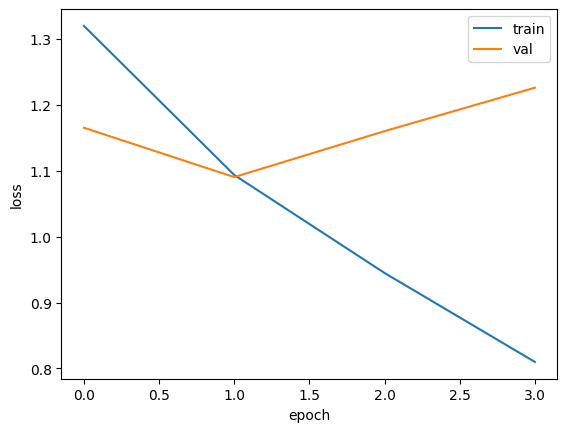

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()